In [2]:
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-white')
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

ImportError: cannot import name '_validate_lengths' from 'numpy.lib.arraypad' (/home/anaconda/lib/python3.7/site-packages/numpy/lib/arraypad.py)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO  
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

In [3]:
import pickle
df=pd.read_pickle("./LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


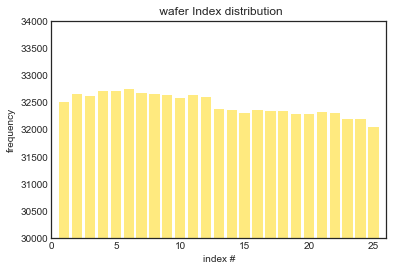

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

In [5]:
df = df.drop(['waferIndex'], axis = 1)

In [6]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
361279,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1080.0,lot21631,[],[],"(35, 40)"
382571,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2393.0,lot22876,[],[],"(52, 59)"
41881,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot3662,[],[],"(25, 27)"
408166,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7870.0,lot24379,[],[],"(63, 160)"
692368,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1129.0,lot42715,[[Test]],[[none]],"(39, 37)"


In [7]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel
mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest={'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

In [8]:
tol_wafers = df.shape[0]

In [9]:
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index()
df_nonpattern = df[(df['failureNum']==8)]
df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]

(172950, 25519, 147431)

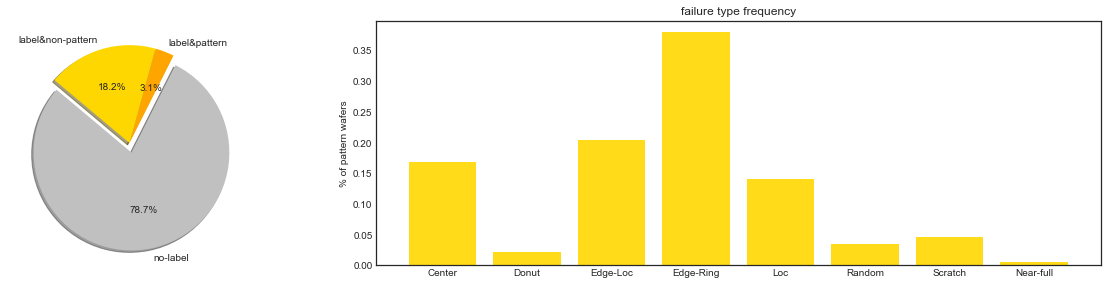

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[tol_wafers-df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

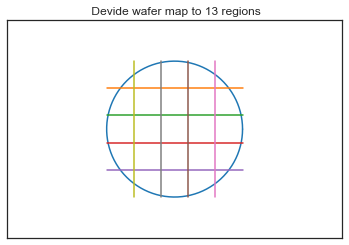

In [11]:
an = np.linspace(0, 2*np.pi, 100)
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [12]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [13]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

In [14]:
def change_val(img):
    img[img==1] =0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

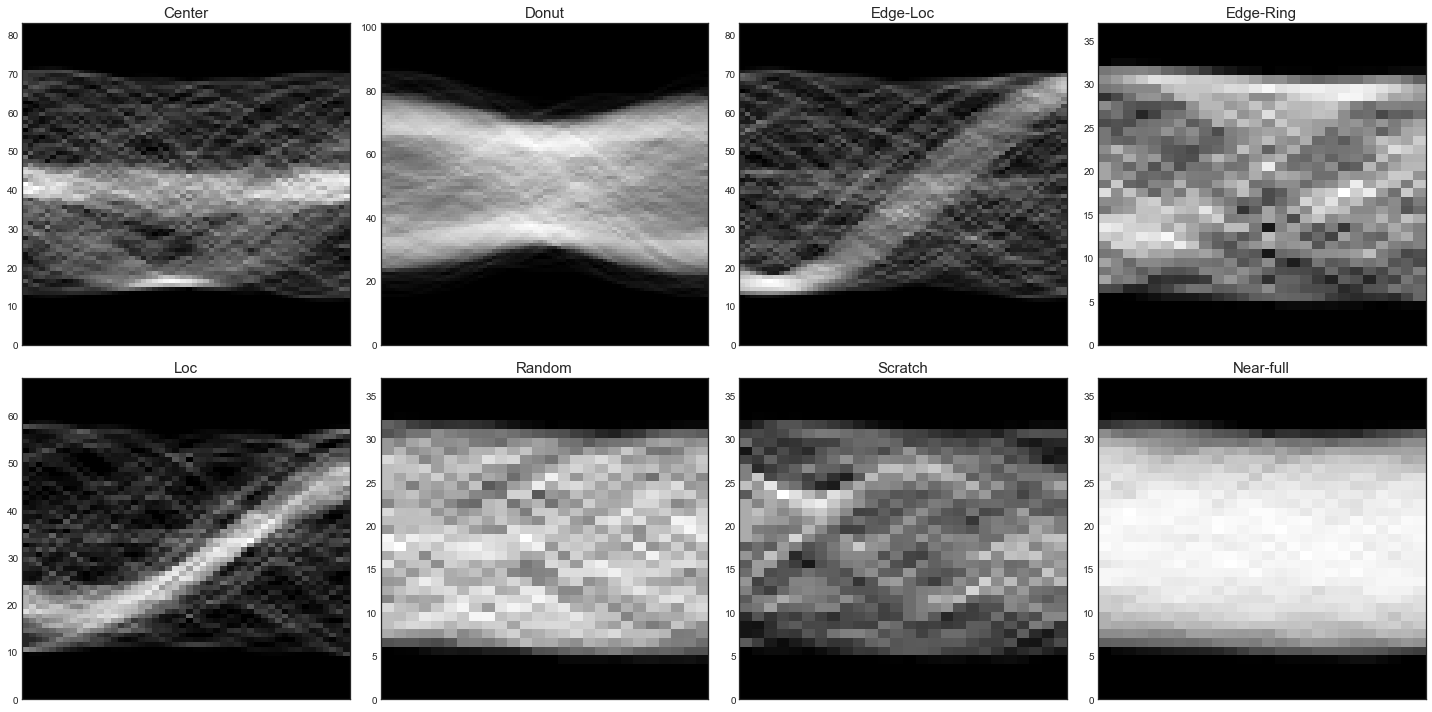

In [15]:
x = [9,340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

In [16]:
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xMean_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew

def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew  

In [17]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.waferMap.apply(cubic_inter_std)

In [18]:
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)
    
    img_labels = measure.label(img, neighbors=4, connectivity=1, background=0)

    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    prop = measure.regionprops(img_labels)
    prop_area = prop[no_region].area/norm_area
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    
    prop_cent = prop[no_region].local_centroid 
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    prop_ecc = prop[no_region].eccentricity  
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [140]:
#df_all=df_withpattern_copy.copy()

a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
e=[df_all.fail_all[i] for i in range(df_all.shape[0])] 
f=[df_all.fail_etc[i] for i in range(df_all.shape[0])] 
g=[df_all.fail_only[i] for i in range(df_all.shape[0])] 
h=[df_all.fail_cycle[i] for i in range(df_all.shape[0])] 
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c)),axis=1) #59 in total

AxisError: axis 1 is out of bounds for array of dimension 1

In [113]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

In [132]:
from sklearn.model_selection import train_test_split

X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({3: 7299, 2: 3860, 0: 3238, 4: 2677, 6: 905, 5: 640, 1: 404, 7: 116})
Testing target statistics: Counter({3: 2381, 2: 1329, 0: 1056, 4: 916, 6: 288, 5: 226, 1: 151, 7: 33})


In [135]:
X_train

,fea_reg,fea_cub_mean,fea_cub_std,fea_geom,fail_all,fail_etc,fail_only,fail_cycle
18204,"[9.62962962962963, 10.344827586206897, 25.9259...",[ 0.00000000e+00 4.29977019e-06 1.21285970e-...,[ 0.00000000e+00 9.86575583e-06 2.78288773e-...,"(0.07790549169859515, 1.3168455837458994, 0.41...",0.0104,0.0460,0.0415,0.0000
15442,"[14.074074074074074, 16.57142857142857, 16.296...",[ 0.00000000e+00 -1.73472348e-20 -1.38777878e-...,[ 0.00000000e+00 -3.46944695e-20 0.00000000e+...,"(0.0637037037037037, 0.7853819586471426, 0.241...",0.0023,0.3093,0.1626,0.0769
22194,"[7.335907335907336, 10.826210826210826, 14.496...",[ 0.00000000e+00 1.05784611e-06 -8.83005550e-...,[ 0.00000000e+00 1.96993704e-06 -1.64434630e-...,"(0.02356202356202356, 0.5369168185369803, 0.18...",0.0040,0.1430,0.2494,0.1319
22211,"[8.494208494208493, 16.80911680911681, 9.82800...",[ 0.00000000e+00 3.12485407e-07 -2.60837891e-...,[ 0.00000000e+00 1.09308787e-06 -9.12422556e-...,"(0.02286902286902287, 0.5228286983261381, 0.26...",0.0073,0.2258,0.3339,0.4725
22773,"[7.8431372549019605, 7.352941176470589, 12.352...",[ 0.00000000e+00 5.60203795e-07 -2.59119735e-...,[ 0.00000000e+00 3.99124837e-05 -1.90973314e-...,"(0.01384083044982699, 0.2667961121136905, 0.19...",0.0023,0.3093,0.1626,0.0769
651,"[9.062170706006324, 7.928388746803069, 9.99194...",[ 0.00000000e+00 1.49452003e-08 -9.05921249e-...,[ 0.00000000e+00 2.51019367e-08 -1.52158401e-...,"(0.027198729402422076, 1.3505048831940678, 0.8...",0.9728,0.2071,0.0745,0.2747
8022,"[2.766798418972332, 2.2413793103448274, 9.0062...",[ 0.00000000e+00 8.81669933e-08 2.69467524e-...,[ 0.00000000e+00 1.51621712e-07 4.63406154e-...,"(0.009745127436281859, 0.29487106880023567, 0....",0.0073,0.2258,0.3339,0.4725
15084,"[12.592592592592592, 17.142857142857142, 17.03...",[ 0.00000000e+00 -1.73472348e-20 0.00000000e+...,[ 0.00000000e+00 1.73472348e-20 -1.38777878e-...,"(0.037037037037037035, 0.536132347730365, 0.19...",0.0023,0.3093,0.1626,0.0769
177,"[10.0, 10.256410256410255, 18.58974358974359, ...",[ 0.00000000e+00 -3.47784002e-05 -2.77382485e-...,[ 0.00000000e+00 -6.31994102e-05 -1.52763905e-...,"(0.020710059171597635, 0.3263569759322527, 0.2...",0.0073,0.2258,0.3339,0.4725
3,"[5.689655172413794, 16.037735849056602, 4.9071...",[ 0.00000000e+00 -1.06691223e-07 -3.26083704e-...,[ 0.00000000e+00 -1.14165922e-07 -3.48928858e-...,"(0.025374105400130124, 0.49864384199138284, 0....",0.0073,0.2258,0.3339,0.4725


## RandomForestClassifier, SVC, LogisticRegression의 ensemble

In [134]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)
v = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')
v.fit(X_train, y_train)

In [24]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, v):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression 0.8528213166144201


/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier 0.8832288401253918


/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC 0.6898119122257054


/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ds4user4/miniconda3/envs/dm_env/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


VotingClassifier 0.8564263322884013


In [22]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
k_fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

## Random Forest Classifier에 대한 Grid Search

In [23]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
rf_param_grid = {"criterion":["gini"]}
gsRFC = GridSearchCV(RFC, rf_param_grid, cv=k_fold, scoring="accuracy",verbose=1)
gsRFC.fit(X_train, y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.1s finished


0.8817075082292701

## Gradient Boosting Classifier에 대한 Grid Search

In [24]:
from sklearn.ensemble import GradientBoostingClassifier
GBC = GradientBoostingClassifier()
gb_param_grid = { "learning_rate":[0.1],
                 }
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=k_fold, scoring="accuracy",n_jobs=4,verbose=1)
gsGBC.fit(X_train, y_train)
GBC_best = gsRFC.best_estimator_
gsGBC.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:  3.8min finished


0.8998380270651549

## Support Vector Classifier에 대한 Grid Search

In [25]:
from sklearn.svm import SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel':['rbf'], 'gamma':[0.001]}
gsSVMC = GridSearchCV(SVMC,pram_grid = svc_pram_grid, cv = k_fold, scoring="accuracy",n_jobs=4,verbose=1)
gsSVMC.fit(X_train, y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

NameError: name 'svc_pram_grid' is not defined

## XGBoost Classifier에 대한 Grid Search 

In [ ]:
from xgboost.sklearn import  XGBClassifier
XGBC = XGBClassifier()
xgb_param_grid = {'gamma' : [0.01]}
gsXGBC = GridSearchCV(XGBC,param_grid=xgb_param_grid, cv=k_fold, scoring="accuracy", n_jobs=4, verbose=1)

gsXGBC.fit(X_train, y_train)
XGBC_best = gsXGBC.best_estimator_
gsXGBC.best_score_

## 최종 voting

In [ ]:
votingC = VotingClassifier(estimators = [('rfc', RFC_best),j('svc',SVMC_best),('gbc',GBC_best),('xgb',XGBC_best)],voting='hard', n_jobs=4)

votingC = votingC.fit(X_train, y_train)

prediction = votingC.predict(X_test)
prediction

## random forest

In [31]:
ORFC = RandomForestClassifier(max_features=11, random_state=1)
ORFC.fit(X_train, y_train)
pred = ORFC.predict(X_test)

In [32]:
print('accuracy :' , accuracy_score(pred, y_test))

accuracy : 0.8863636363636364


In [ ]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None], "max_features":[10], "min_samples_split":[2],
                 "min_samples_leaf":[1,3,8], "bootstrap":[False], "n_estimators":[100,300],"criterion":["gini"]}
gsRFC = GridSearchCV(RFC, rf_param_grid, cv=k_fold, scoring="accuracy",verbose=1)
gsRFC.fit(X_train, y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

In [1]:
failer1 = pd.read_csv("failer.csv")

NameError: name 'pd' is not defined

In [83]:
failer1 = failer1.parse("failer")

In [84]:
failer1

,failureType,fail_all,fail_etc,fail_only,fail_cycle
0,[['Center']],0.0023,0.3093,0.1626,0.0769
1,[['Donut']],0.0029,0.0421,0.0161,0.0440
2,[['Edge-Loc']],0.0073,0.2258,0.3339,0.4725
3,[['Edge-Ring']],0.9728,0.2071,0.0745,0.2747
4,[['Loc']],0.0040,0.1430,0.2494,0.1319
5,[['Near-full']],0.0003,0.0030,0.0133,0.0000
6,[['Random']],0.0104,0.0460,0.0415,0.0000
7,[['Scratch']],0.0000,0.0238,0.1086,0.0000
8,[['none']],0.0000,0.0000,0.0000,0.0000


In [86]:
df_all.to_excel("df_all1.xlsx")

In [126]:
df_all = pd.read_csv("./df_all_mo.xlsx")

In [127]:
df_all

,A,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,fea_reg,new_waferMap,fea_cub_mean,fea_cub_std,fea_geom,fail_all,fail_etc,fail_only,fail_cycle
0,0,19,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,1683,lot1,[['Training']],[['Loc']],"(45, 48)",4,0,"[3.4722222222222223, 13.703703703703704, 3.472...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[0.00000000e+00 1.08497416e-07 1.97243599e-06 ...,[ 0.00000000e+00 -3.82845256e-07 -6.95996081e-...,"(0.027314814814814816, 0.5954493227790636, 0.1...",0.0040,0.1430,0.2494,0.1319
1,1,36,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Edge-Loc']],"(53, 58)",2,0,"[6.0344827586206895, 11.05121293800539, 5.1724...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -7.35677195e-08 -2.24847309e-...,[ 0.00000000e+00 -1.21146447e-08 -3.70263654e-...,"(0.01626545217957059, 0.42137276857016587, 0.2...",0.0073,0.2258,0.3339,0.4725
2,2,37,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Edge-Loc']],"(53, 58)",2,0,"[5.862068965517241, 11.320754716981133, 5.0397...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -6.74029042e-08 -2.06005593e-...,[0.00000000e+00 9.16671823e-08 2.80165260e-05 ...,"(0.019193233571893297, 0.4595560383749584, 0.2...",0.0073,0.2258,0.3339,0.4725
3,3,38,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Edge-Loc']],"(53, 58)",2,0,"[5.689655172413794, 16.037735849056602, 4.9071...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -1.06691223e-07 -3.26083704e-...,[ 0.00000000e+00 -1.14165922e-07 -3.48928858e-...,"(0.025374105400130124, 0.49864384199138284, 0....",0.0073,0.2258,0.3339,0.4725
4,4,39,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Edge-Loc']],"(53, 58)",2,0,"[11.551724137931034, 13.07277628032345, 5.0397...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -6.79862623e-08 -2.07788528e-...,[ 0.00000000e+00 -2.25202505e-08 -6.88293420e-...,"(0.019843851659076123, 0.5065518560958309, 0.2...",0.0073,0.2258,0.3339,0.4725
5,5,40,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Loc']],"(53, 58)",4,0,"[23.96551724137931, 10.242587601078167, 4.6419...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -1.03664471e-07 -3.16832947e-...,[0.00000000e+00 5.71316274e-08 1.74613170e-05 ...,"(0.0631099544567339, 1.322110409143117, 0.3230...",0.0040,0.1430,0.2494,0.1319
6,6,41,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Edge-Loc']],"(53, 58)",2,0,"[29.48275862068965, 7.547169811320755, 5.83554...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -3.32840680e-08 -1.01727132e-...,[ 0.00000000e+00 1.34136857e-07 4.09966648e-...,"(0.05139882888744307, 0.7927390445455735, 0.33...",0.0073,0.2258,0.3339,0.4725
7,7,42,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Edge-Loc']],"(53, 58)",2,0,"[27.068965517241377, 9.164420485175203, 6.2334...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -2.54501422e-08 -7.77840611e-...,[0.00000000e+00 1.32704193e-07 4.05587953e-05 ...,"(0.04554326610279766, 0.8076505389428378, 0.36...",0.0073,0.2258,0.3339,0.4725
8,8,43,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Edge-Loc']],"(53, 58)",2,0,"[17.93103448275862, 7.412398921832884, 5.17241...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -1.00984913e-07 -3.08643331e-...,[ 0.00000000e+00 -2.28244542e-08 -6.97590894e-...,"(0.02309694209499024, 0.6667406825136332, 0.36...",0.0073,0.2258,0.3339,0.4725
9,9,44,[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,2460,lot2,[['Training']],[['Center']],"(53, 58)",0,0,"[13.275862068965516, 6.064690026954178, 5.1724...",[[0 0 0 ... 0 0 0]\n [0 0 0 ... 0 0 0]\n [0 0 ...,[ 0.00000000e+00 -1.79172085e-07 -5.47609217e-...,[ 0.00000000e